In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import featuretools as ft

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Previous application
Dataset has 1670214 observations and 37 features, no duplicates. Some features have null values, but they will be handeled after feature selection.

In [136]:
previous_application = help_tool.csv_download(r'Archive\home-credit-default-risk\previous_application.csv')
help_tool.first_look(previous_application)

Dataset has 1670214 observations and 37 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
NAME_CONTRACT_TYPE,object,0,0.0
AMT_ANNUITY,float64,372235,22.3
AMT_APPLICATION,float64,0,0.0
AMT_CREDIT,float64,1,0.0
AMT_DOWN_PAYMENT,float64,895844,53.6
AMT_GOODS_PRICE,float64,385515,23.1
WEEKDAY_APPR_PROCESS_START,object,0,0.0
HOUR_APPR_PROCESS_START,int64,0,0.0


In [137]:
previous_application[[
    'DURATION_DECISION_DRAWING', 'DURATION_DECISION_FIRST_DUE', 'DURATION_DUE', 
    'DURATION_DUE_VERSION', 'DURATION_TERMINATION'
    ]] = duckdb.query("""
             SELECT 
             ABS(DAYS_DECISION - DAYS_FIRST_DRAWING) AS DURATION_DECISION_DRAWING,
             ABS(DAYS_DECISION - DAYS_FIRST_DUE) AS DURATION_DECISION_FIRST_DUE,
             ABS(DAYS_FIRST_DUE - DAYS_LAST_DUE) AS DURATION_DUE,
             ABS(DAYS_LAST_DUE - DAYS_LAST_DUE_1ST_VERSION) AS DURATION_DUE_VERSION,
             ABS(DAYS_DECISION - DAYS_TERMINATION) AS DURATION_TERMINATION
             FROM previous_application
              """).to_df()

previous_application.drop(columns=['DAYS_DECISION', 'DAYS_FIRST_DRAWING',
'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_TERMINATION',
'HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START'], inplace=True
)

## Object features
Before feature selection, object features will be numerically encoded or grouped.

In [138]:
previous_application = help_tool.convert_flags(previous_application)

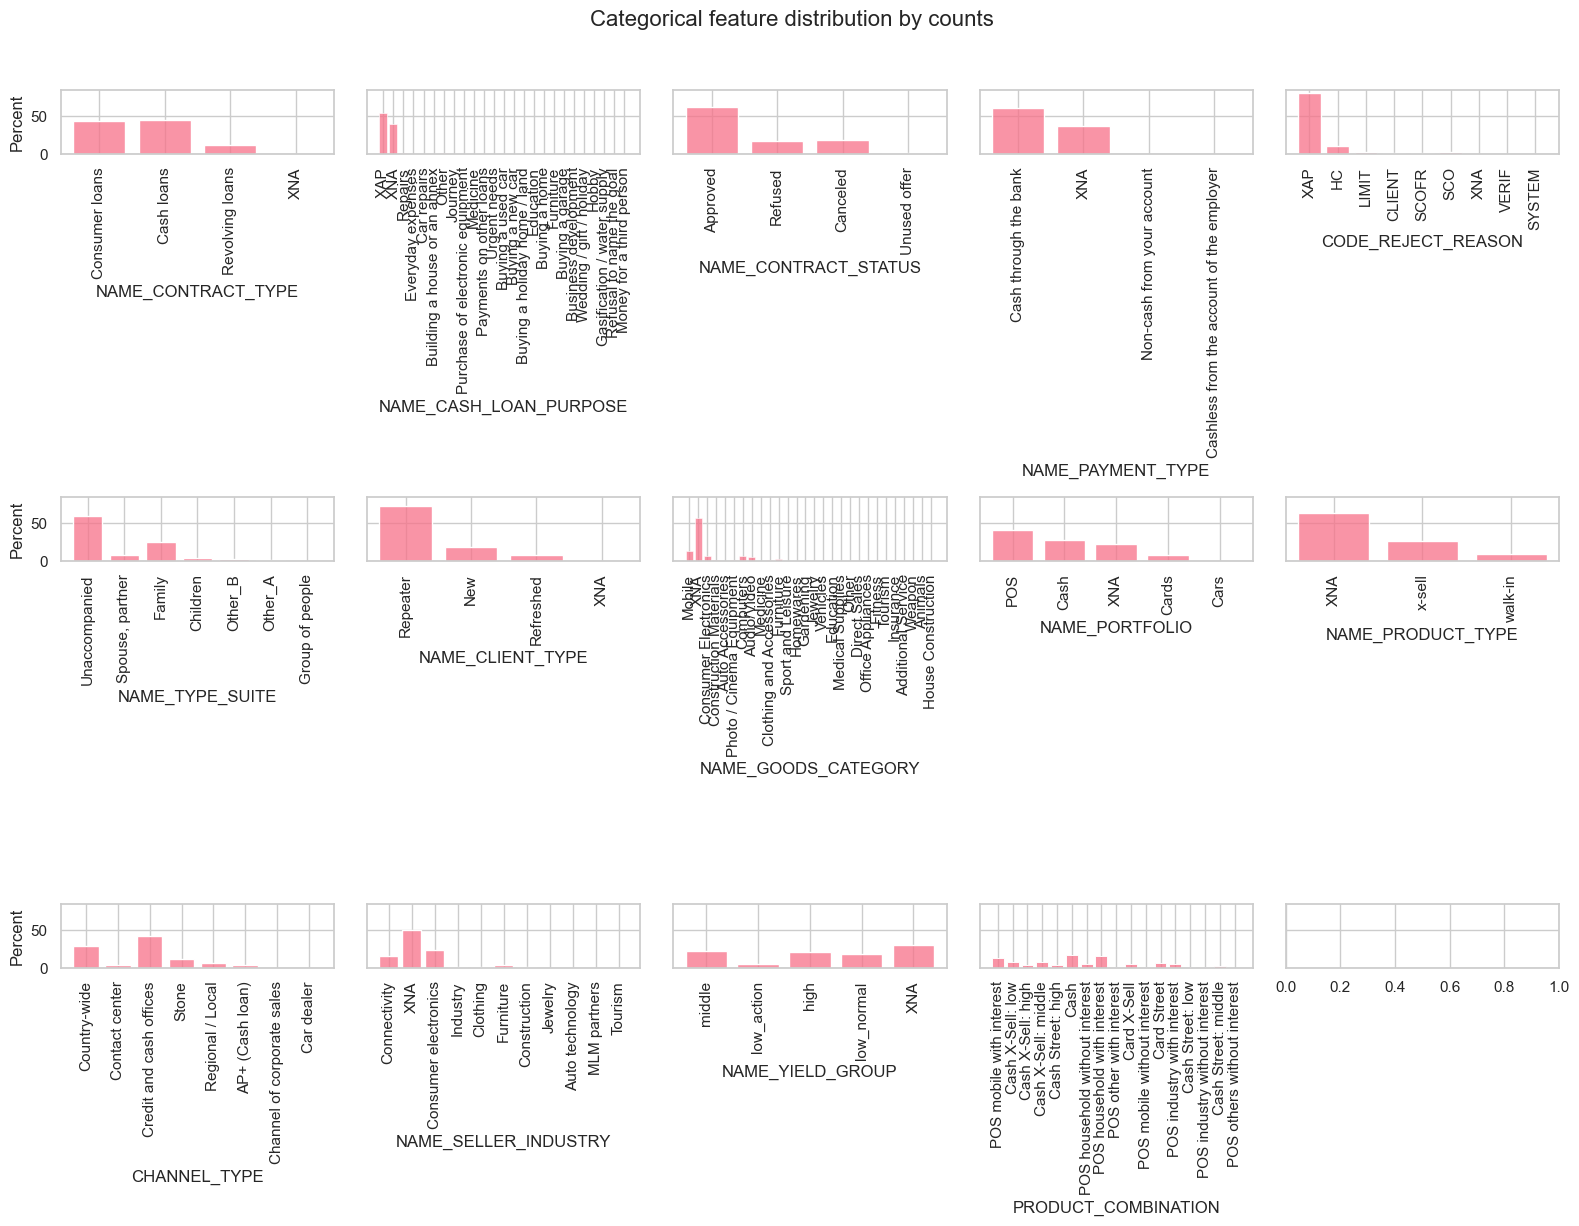

In [139]:
object_columns = previous_application.select_dtypes(include=['object']).columns.tolist()



fig, axes = plt.subplots(3, 5, figsize=(16, 12), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.histplot(data=previous_application, x=col, bins=20, multiple="dodge", shrink=.8,
                 ax=axes[i], legend=True, stat="percent")
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

In [140]:
previous_application = help_tool.product_combination(previous_application)
previous_application['NAME_CLIENT_TYPE'] = help_tool.client_type_encoding(previous_application, 'NAME_CLIENT_TYPE')
# previous_application = help_tool.weekday_encoding(previous_application)
previous_application['NAME_TYPE_SUITE'] = help_tool.accompanied(previous_application, 'NAME_TYPE_SUITE')
previous_application['NAME_YIELD_GROUP'] = previous_application['NAME_YIELD_GROUP'].apply(help_tool.yield_group)
previous_application['CONTRACT_STATUS'] = help_tool.contract_status(previous_application, 'NAME_CONTRACT_STATUS')

In [141]:
previous_application['NAME_GOODS_CATEGORY'] = help_tool.top_five_categories(previous_application, 'NAME_GOODS_CATEGORY', 3)
previous_application['PAYMENT_TYPE_Cash_through_the_bank'] = help_tool.payment_type(previous_application, 'NAME_PAYMENT_TYPE')

In [142]:
previous_application['NAME_PRODUCT_TYPE'] = previous_application['NAME_PRODUCT_TYPE'].apply(help_tool.product_type)

### NAME_CASH_LOAN_PURPOSE
90% of Cash loans responded with XNA (unknown), while Consumer loans and Revolving loans have subvalues XAP (Application Error). NAME_CASH_LOAN_PURPOSE will be dropped.

In [143]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_CASH_LOAN_PURPOSE']].value_counts() / previous_application[['NAME_CONTRACT_TYPE']].value_counts() * 100

NAME_CONTRACT_TYPE  NAME_CASH_LOAN_PURPOSE          
Cash loans          XNA                                  90.684941
                    Repairs                               3.179039
                    Other                                 2.087879
                    Urgent needs                          1.125271
                    Buying a used car                     0.386327
                    Building a house or an annex          0.360242
                    Everyday expenses                     0.323188
                    Medicine                              0.290816
                    Payments on other loans               0.258309
                    Education                             0.210420
                    Journey                               0.165741
                    Purchase of electronic equipment      0.141930
                    Buying a new car                      0.135375
                    Wedding / gift / holiday              0.128687
         

In [144]:
previous_application.drop(columns='NAME_CASH_LOAN_PURPOSE', inplace=True)

### NAME_PORTFOLIO
NAME_PORTFOLIO has duplicate information for NAME_CONTRACT_TYPE or have missing values, this fetaure will be dropped.

In [145]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO']].value_counts() / previous_application[['NAME_CONTRACT_TYPE']].value_counts() * 100

NAME_CONTRACT_TYPE  NAME_PORTFOLIO
Cash loans          Cash               61.743181
                    XNA                38.256819
Consumer loans      POS                94.769259
                    XNA                 5.172454
                    Cars                0.058287
Revolving loans     Cards              75.057982
                    XNA                24.942018
XNA                 XNA               100.000000
Name: count, dtype: float64

In [146]:
previous_application.drop(columns='NAME_PORTFOLIO', inplace=True)

CODE_REJECT_REASON:
* XAP: Application was approved.
* HC: High Cost – the loan was considered too expensive for the applicant.
* LIMIT: Credit limit reached.
* SCO: Score too low – the applicant’s credit score was insufficient.
* SYSTEM: Other reasons related to the system or internal processes.
* VERIF: Verification issues – problems with verifying the applicant's information.
* XNA: Not applicable or no specific reason. <br>
'HC' is the biggest caterory for rejection.

NAME_GOODS_CATEGORY:
* Has no values for Cash Loans and Revolving Loans.
* Values only for Customer Loans. 
NAME_GOODS_CATEGORY will be dropped as values are available only for 1/3 of products.

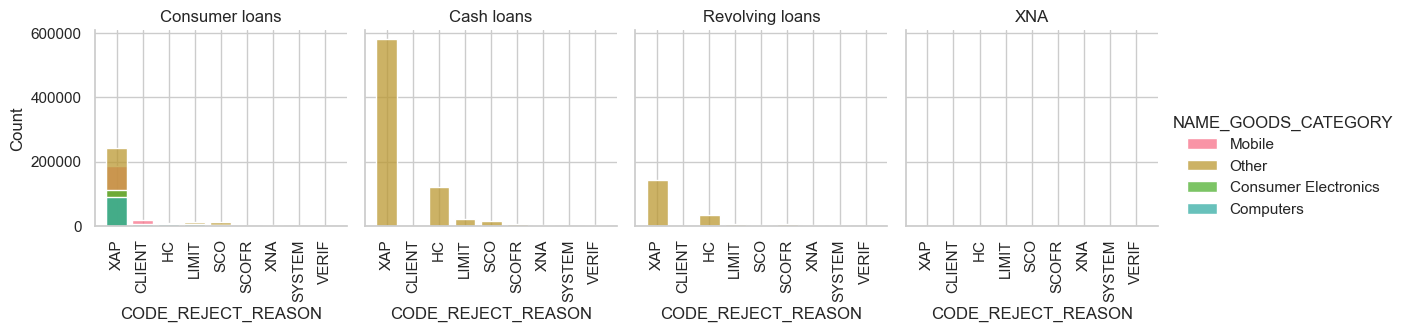

In [147]:
g = sns.FacetGrid(previous_application, col="NAME_CONTRACT_TYPE",  hue="NAME_GOODS_CATEGORY"
                  )
g.map(sns.histplot, 'CODE_REJECT_REASON', bins=20, multiple="dodge", shrink=.8)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.tight_layout()
g.set_xticklabels(rotation=90)
g.add_legend()
plt.show()

In [148]:
previous_application['CODE_REJECT_REASON'] = previous_application['CODE_REJECT_REASON'].apply(help_tool.reject_reason)
previous_application.drop(columns='NAME_GOODS_CATEGORY', inplace=True)

PRODUCT_PLACE 'industry' and 'other' will be grouped

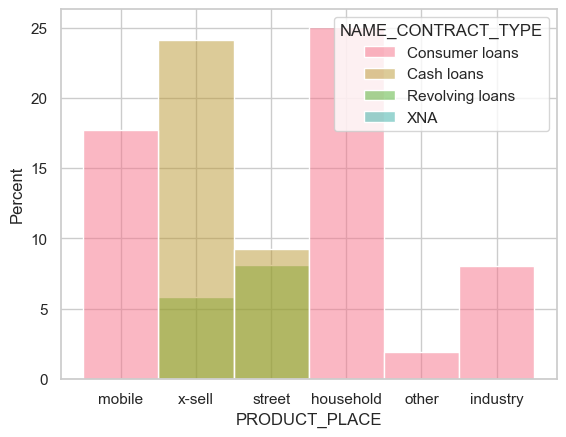

In [149]:
sns.histplot(data=previous_application, x='PRODUCT_PLACE', stat='percent', hue='NAME_CONTRACT_TYPE')
plt.show()

In [150]:
previous_application['PRODUCT_PLACE'] = previous_application['PRODUCT_PLACE'].apply(help_tool.product_place)

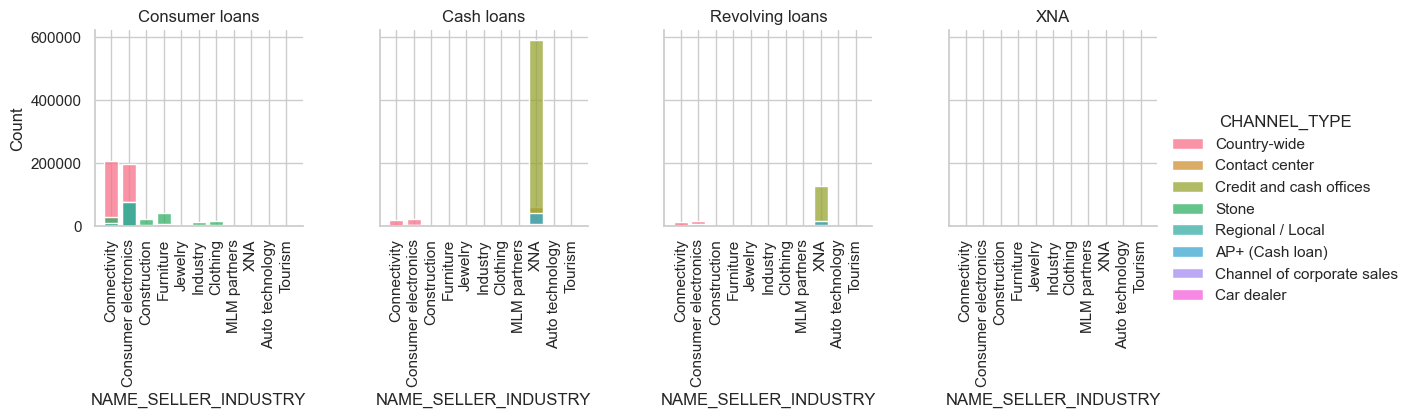

In [151]:
g = sns.FacetGrid(previous_application, col="NAME_CONTRACT_TYPE", hue="CHANNEL_TYPE")
g.map(sns.histplot, 'NAME_SELLER_INDUSTRY', bins=20, multiple="dodge", shrink=.8)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.tight_layout()
g.set_xticklabels(rotation=90)
g.add_legend()
plt.show()

In [152]:
previous_application['NAME_SELLER_INDUSTRY'] = help_tool.top_five_categories(previous_application, 'NAME_SELLER_INDUSTRY', 3)
previous_application['CHANNEL_TYPE'] = help_tool.top_five_categories(previous_application, 'CHANNEL_TYPE', 3)

In [153]:
previous_application.replace({'XNA': np.nan}, inplace=True)

In [154]:
previous_application_expanded = help_tool.dummy_columns(previous_application, previous_application.select_dtypes(include=['object']).columns.tolist())

# Adding groups from sub-data AND Target

In [156]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET']]

In [157]:
sorted_previous_application = duckdb.query("""
 
             SELECT A.*, B.TARGET
             FROM previous_application_expanded A
             INNER JOIN application_train B
             ON A.SK_ID_CURR = B.SK_ID_CURR

             """).to_df()

sorted_previous_application.shape

(1413701, 48)

# Feature Selection

Target has 8% of positive values.

In [158]:
sorted_previous_application['TARGET'].value_counts() / sorted_previous_application['TARGET'].count() * 100

TARGET
0    91.344704
1     8.655296
Name: count, dtype: float64

In [159]:
sorted_previous_application.drop(
    columns= help_model.zero_variance_features(sorted_previous_application.drop(columns='TARGET')), 
    inplace = True
    )

In [160]:
sorted_previous_application.shape

(1413701, 39)

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

In [161]:
# plt.figure(figsize=(20, 6))
# help_stats.biserial_heatmap(sorted_previous_application.fillna(-1), sorted_previous_application.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

### Light XGB

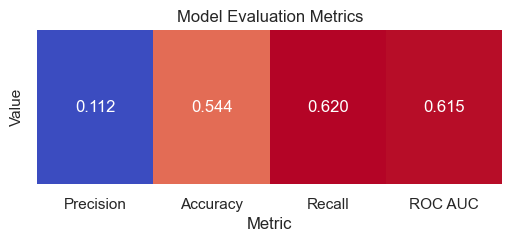

In [162]:
feature_importance_previous_application = help_model.model_feature_importance_target(sorted_previous_application)

Feature importance is below 50 for product type and categorical features. Sadly, also the clustering features are low on importance (as was expected with large amount of missing rows)

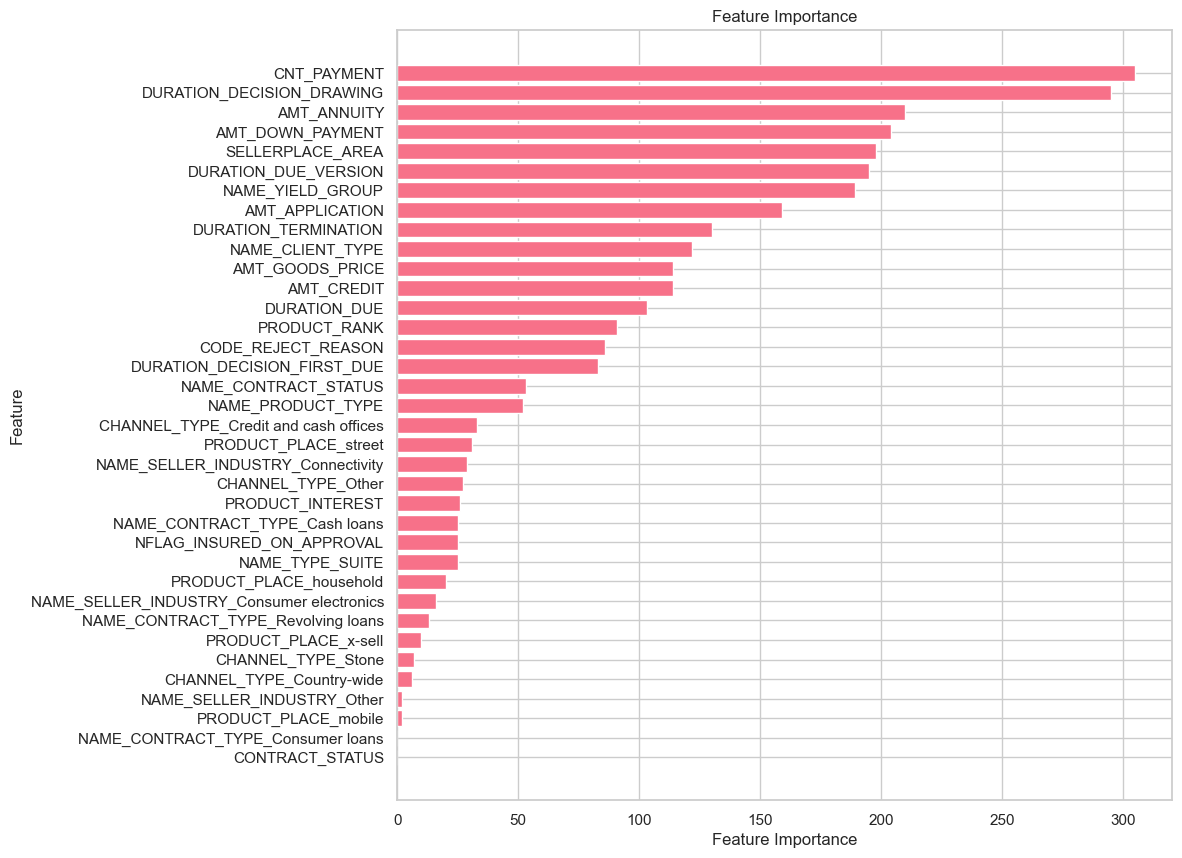

In [163]:
help_model.plot_feature_importance(feature_importance_previous_application.head(40))

# Selected feature EDA

In [169]:
selected_features = feature_importance_previous_application[feature_importance_previous_application['importance'] > 100]['feature'].to_list()

CNT_PAYMENT


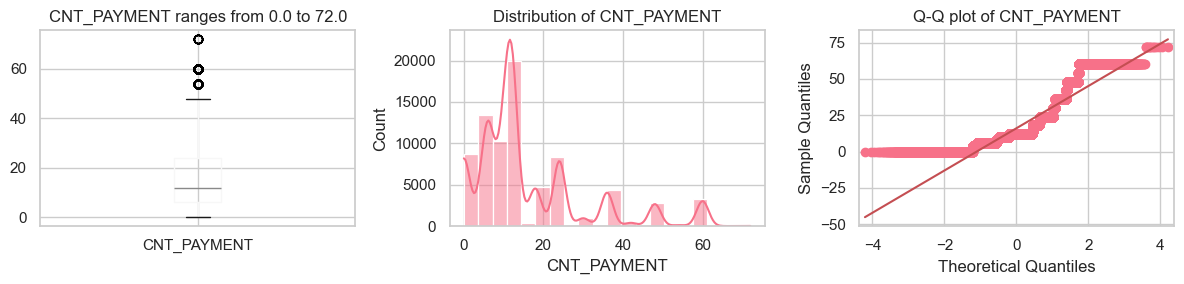

DURATION_DECISION_DRAWING


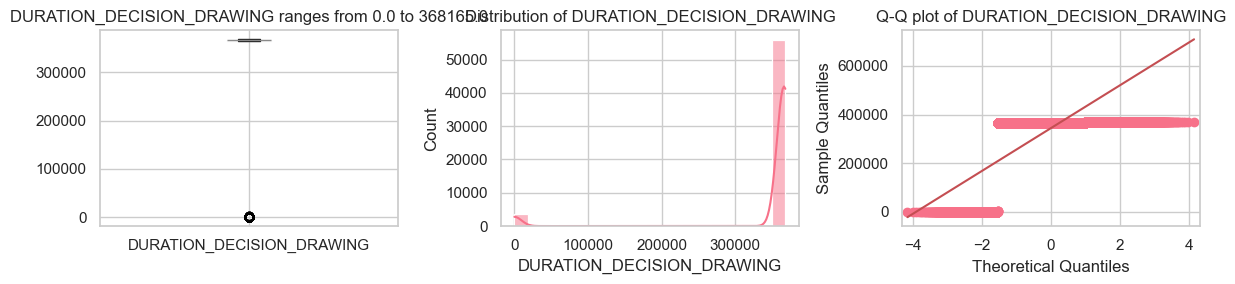

AMT_ANNUITY


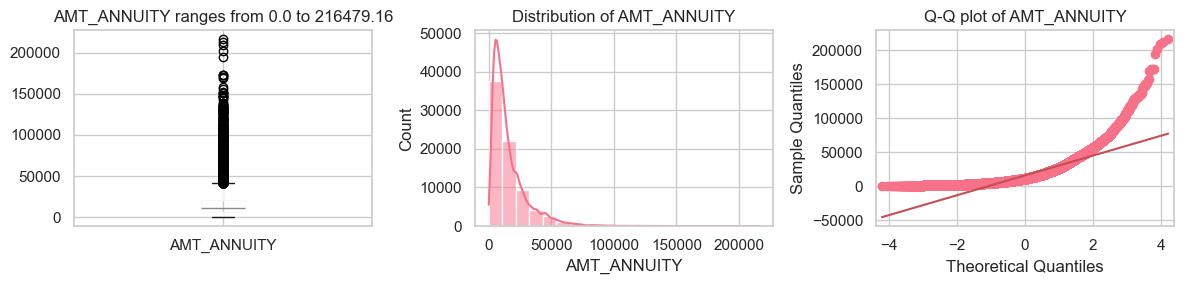

AMT_DOWN_PAYMENT


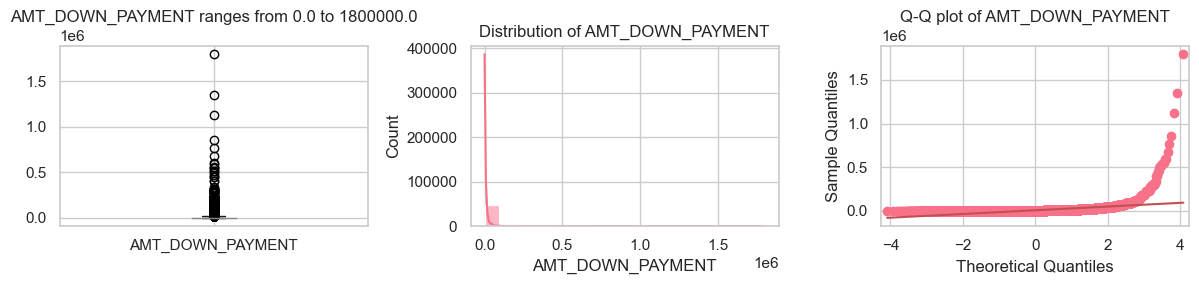

SELLERPLACE_AREA


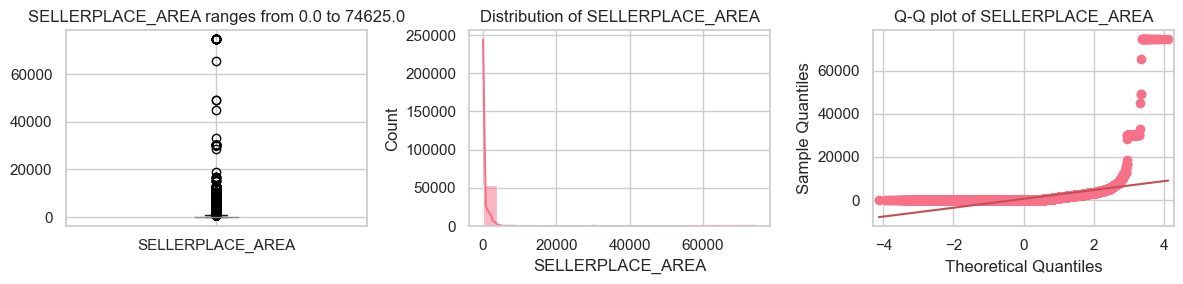

DURATION_DUE_VERSION


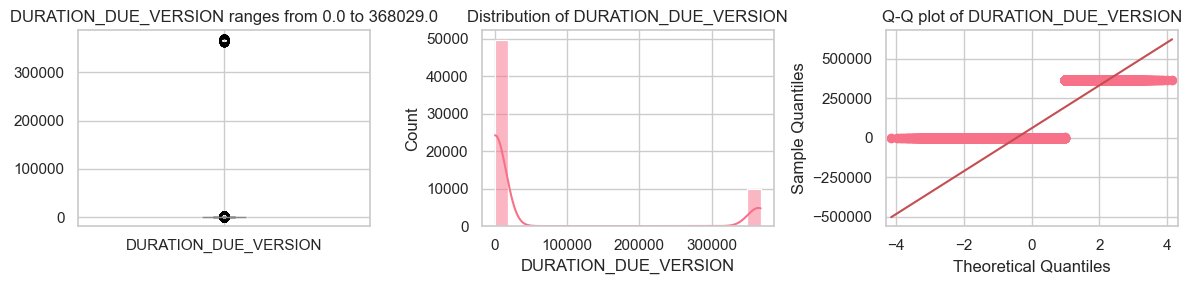

NAME_YIELD_GROUP


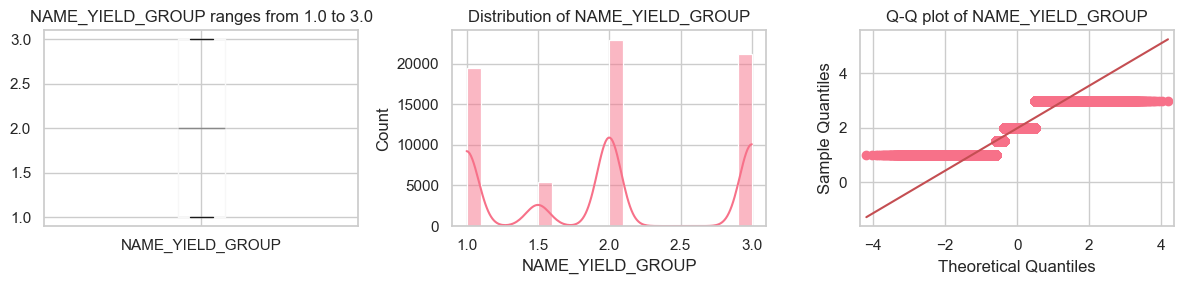

AMT_APPLICATION


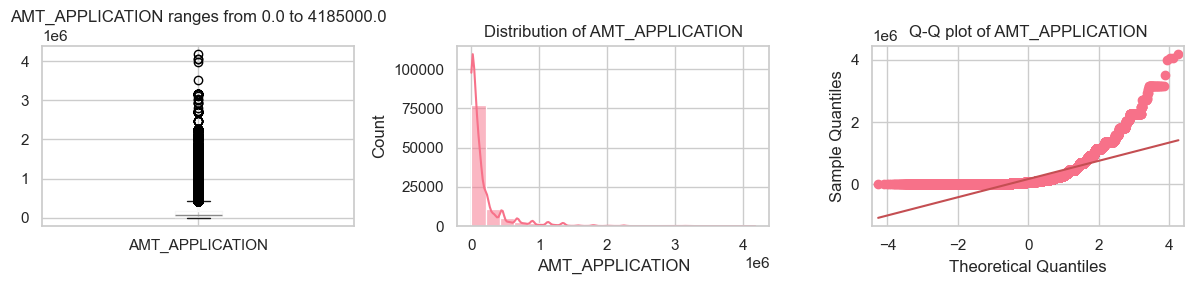

DURATION_TERMINATION


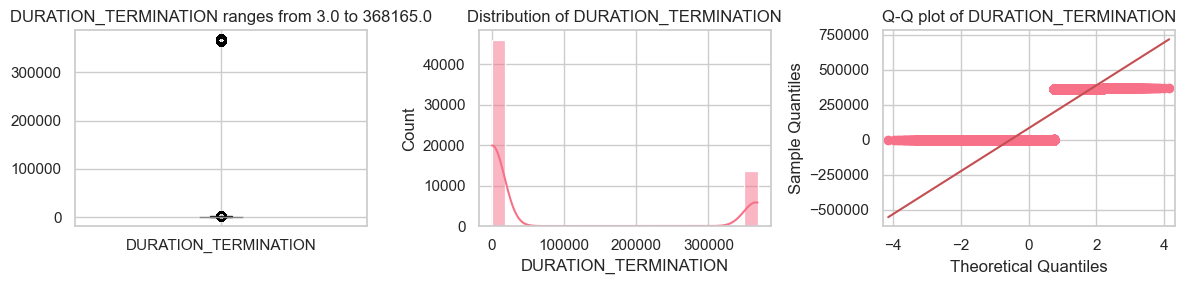

NAME_CLIENT_TYPE


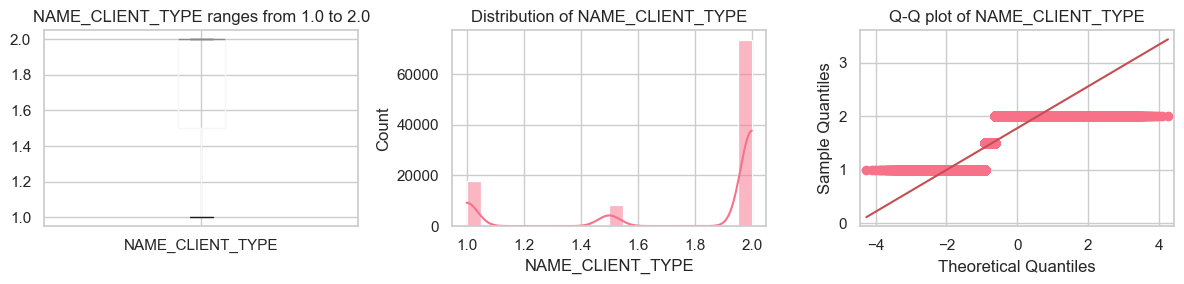

AMT_GOODS_PRICE


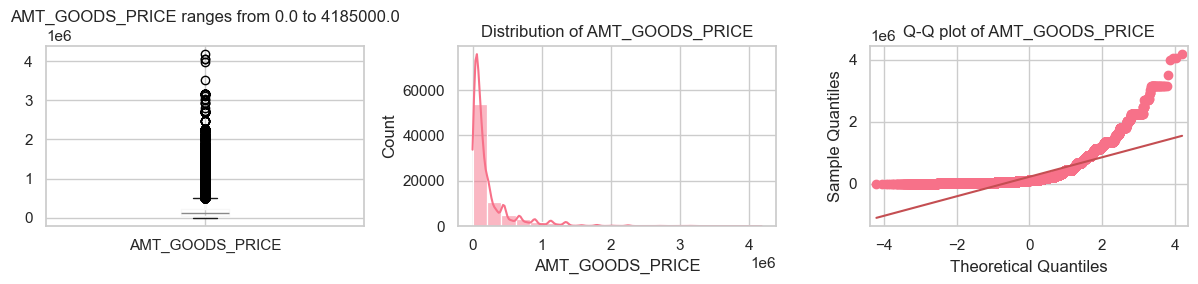

AMT_CREDIT


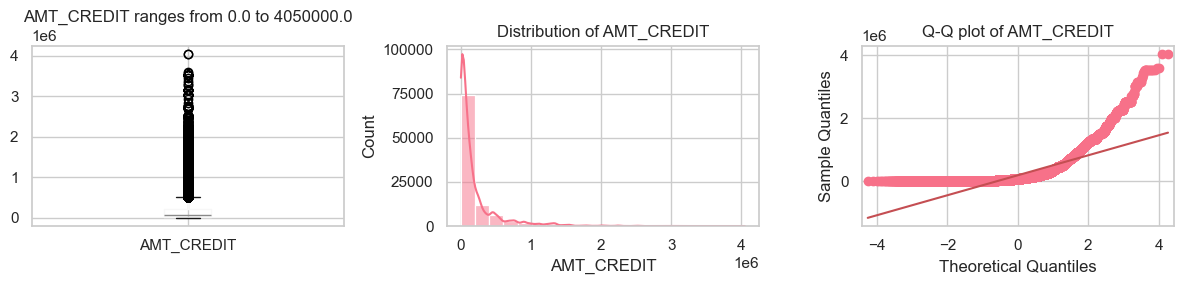

DURATION_DUE


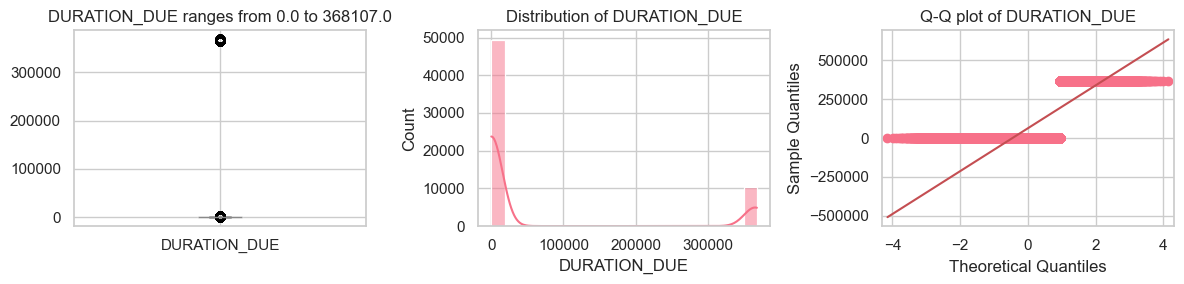

In [187]:
help_visuals.distribution_check(previous_application[selected_features].sample(100000, random_state=42))

In [182]:
for feature in previous_application[selected_features].filter(like='DUR', axis=1).columns.to_list():
    previous_application[f'FLAG_{feature}'] = np.where(previous_application[feature].isna(), 
                  np.nan, 
                  np.where(previous_application[feature] > 200000, 1, 0))

In [190]:
# previous_application['SELLERPLACE_AREA'] = previous_application['SELLERPLACE_AREA'].replace({-1: np.nan})

In [194]:
selected_features = ['CNT_PAYMENT',
 'FLAG_DURATION_DECISION_DRAWING',
 'AMT_ANNUITY',
 'AMT_DOWN_PAYMENT',
 'SELLERPLACE_AREA',
 'FLAG_DURATION_DUE_VERSION',
 'NAME_YIELD_GROUP',
 'AMT_APPLICATION',
 'FLAG_DURATION_TERMINATION',
 'NAME_CLIENT_TYPE',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'FLAG_DURATION_DUE']

In [197]:
selected_features

['CNT_PAYMENT',
 'FLAG_DURATION_DECISION_DRAWING',
 'AMT_ANNUITY',
 'AMT_DOWN_PAYMENT',
 'SELLERPLACE_AREA',
 'FLAG_DURATION_DUE_VERSION',
 'NAME_YIELD_GROUP',
 'AMT_APPLICATION',
 'FLAG_DURATION_TERMINATION',
 'NAME_CLIENT_TYPE',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'FLAG_DURATION_DUE']

In [198]:
previous_application[[
    'RATIO_ANNUITY_PAYMENT', 'RATIO_ANNUITY_DOWN_PAYMENT', 'RATIO_ANNUITY_APPLICATION', 
    'RATIO_GOODS_PRICE_CREDIT', 'RATIO_SELLERPLACE_AREA_DOWN_PAYMENT'
    ]] = duckdb.query("""
             SELECT 
             (AMT_ANNUITY / CNT_PAYMENT) AS RATIO_ANNUITY_PAYMENT,
             (AMT_ANNUITY / AMT_DOWN_PAYMENT) AS RATIO_ANNUITY_DOWN_PAYMENT,
             (AMT_ANNUITY / AMT_APPLICATION) AS RATIO_ANNUITY_APPLICATION,
             (AMT_GOODS_PRICE / AMT_CREDIT) AS RATIO_GOODS_PRICE_CREDIT,
             (SELLERPLACE_AREA / AMT_DOWN_PAYMENT) AS RATIO_SELLERPLACE_AREA_DOWN_PAYMENT
             FROM previous_application
""").to_df()


derivative_features = ['RATIO_ANNUITY_PAYMENT', 'RATIO_ANNUITY_DOWN_PAYMENT', 'RATIO_ANNUITY_APPLICATION', 
    'RATIO_GOODS_PRICE_CREDIT', 'RATIO_SELLERPLACE_AREA_DOWN_PAYMENT']

In [238]:
previous_application_agg = help_model.aggregated_features(previous_application[['SK_ID_CURR'] + derivative_features + selected_features], 'SK_ID_CURR')

## Adding sub-data

In [254]:
sorted_credit_card_balance_feature_matrix = help_tool.csv_download(r'Archive\home-credit-default-risk\sorted_credit_card_balance_feature_matrix.csv')[['SK_ID_PREV', 'SK_ID_CURR', 'Cluster_credit_card']]
sorted_installments_payments_feature_matrix = help_tool.csv_download(r'Archive\home-credit-default-risk\sorted_installments_payments_feature_matrix.csv')[['SK_ID_PREV', 'SK_ID_CURR', 'Cluster_installments_payments']]
sorted_pos_cash_feature_matrix = help_tool.csv_download(r'Archive\home-credit-default-risk\sorted_pos_cash_feature_matrix.csv')[['SK_ID_PREV', 'SK_ID_CURR', 'Cluster_pos_cash']]

In [213]:
sorted_credit_card_balance_feature_matrix['Cluster_credit_card'] = sorted_credit_card_balance_feature_matrix['Cluster_credit_card'].astype(str)
sorted_credit_card_balance_feature_matrix = help_tool.dummy_columns(sorted_credit_card_balance_feature_matrix, ['Cluster_credit_card'])

sorted_installments_payments_feature_matrix['Cluster_installments_payments'] = sorted_installments_payments_feature_matrix['Cluster_installments_payments'].astype(str)
sorted_installments_payments_feature_matrix = help_tool.dummy_columns(sorted_installments_payments_feature_matrix, ['Cluster_installments_payments'])

sorted_pos_cash_feature_matrix['Cluster_pos_cash'] = sorted_pos_cash_feature_matrix['Cluster_pos_cash'].astype(str)
sorted_pos_cash_feature_matrix = help_tool.dummy_columns(sorted_pos_cash_feature_matrix, ['Cluster_pos_cash'])

In [239]:
sub_data_clusters = duckdb.query("""
             WITH 

             card_balance_agg AS (
             SELECT 
             SK_ID_CURR,
             SUM(Cluster_credit_card_0) AS Cluster_credit_card_0,
             SUM(Cluster_credit_card_1) AS Cluster_credit_card_1,
             SUM(Cluster_credit_card_2) AS Cluster_credit_card_2,
             FROM sorted_credit_card_balance_feature_matrix
             GROUP BY SK_ID_CURR
             )

             ,installments_payments_agg AS (
             SELECT 
             SK_ID_CURR,
             SUM(Cluster_installments_payments_0) AS Cluster_installments_payments_0,
             SUM(Cluster_installments_payments_1) AS Cluster_installments_payments_1,
             SUM(Cluster_installments_payments_2) AS Cluster_installments_payments_2,
             FROM sorted_installments_payments_feature_matrix
             GROUP BY SK_ID_CURR
             )

             ,pos_cash_agg AS (
             SELECT 
             SK_ID_CURR,
             SUM(Cluster_pos_cash_0) AS Cluster_pos_cash_0,
             SUM(Cluster_pos_cash_1) AS Cluster_pos_cash_1,
             SUM(Cluster_pos_cash_2) AS Cluster_pos_cash_2,
             FROM sorted_pos_cash_feature_matrix
             GROUP BY SK_ID_CURR
             )

             SELECT *
             FROM previous_application_agg A
             LEFT JOIN card_balance_agg B ON A.SK_ID_CURR = B.SK_ID_CURR
             LEFT JOIN installments_payments_agg C ON A.SK_ID_CURR = C.SK_ID_CURR
             LEFT JOIN pos_cash_agg D ON A.SK_ID_CURR = D.SK_ID_CURR
 """).to_df().drop(columns=['SK_ID_CURR_1', 'SK_ID_CURR_2', 'SK_ID_CURR_3'])

# Feature importance

In [241]:
sub_data_clusters = duckdb.query("""
 
             SELECT A.*, B.TARGET
             FROM sub_data_clusters A
             LEFT JOIN application_train B
             ON A.SK_ID_CURR = B.SK_ID_CURR

             """).to_df()

sub_data_clusters.shape

(338857, 79)

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

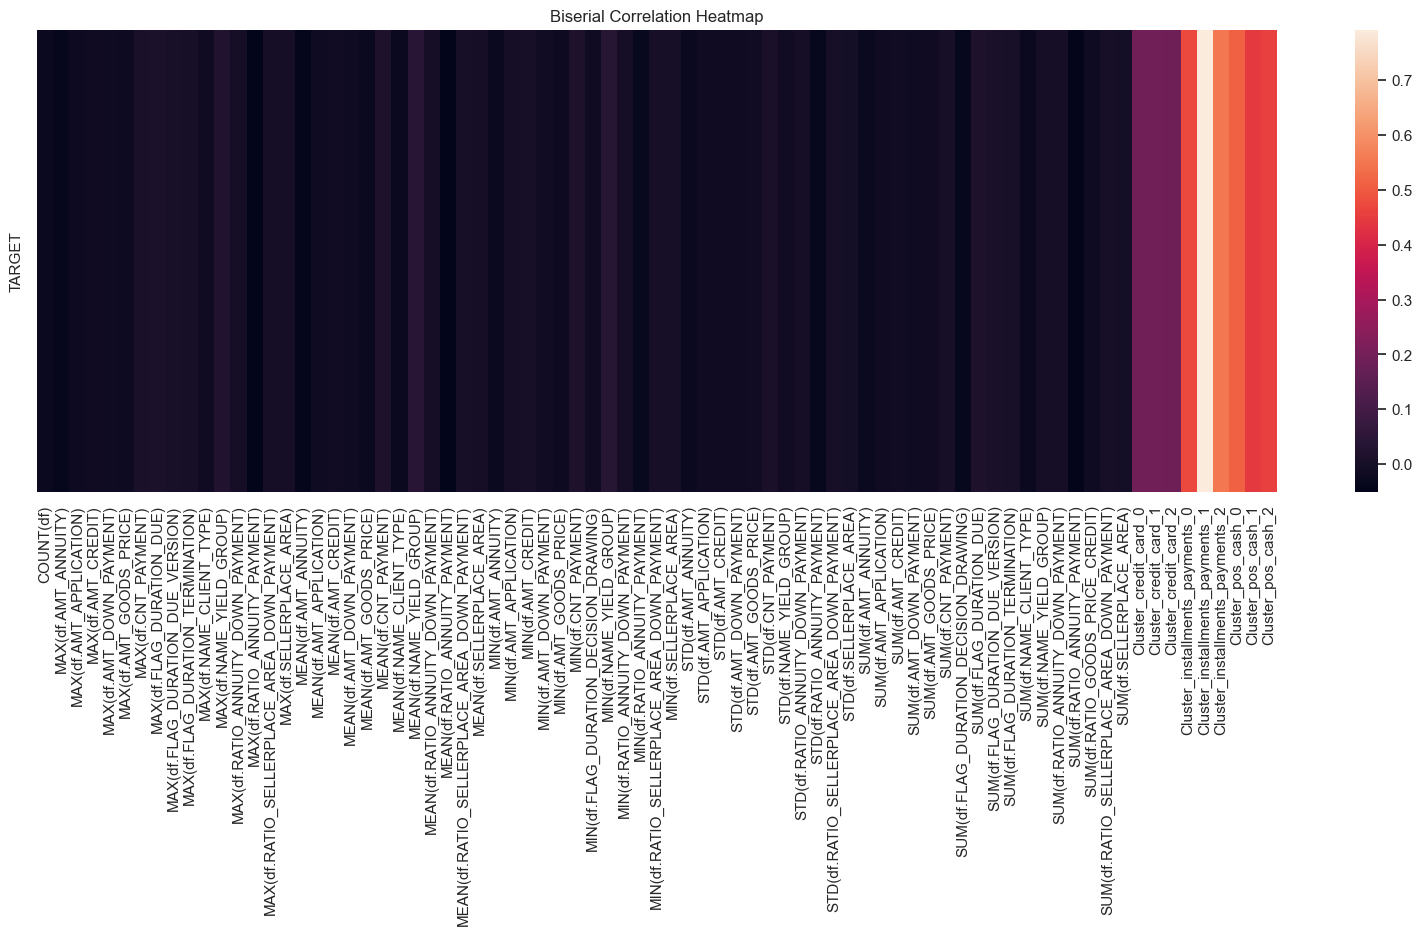

In [242]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(sub_data_clusters.fillna(-1), sub_data_clusters.drop(columns=['SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

### Light XGB

In [248]:
sub_data_clusters.dropna(subset='TARGET')['TARGET'].isna().sum()

0

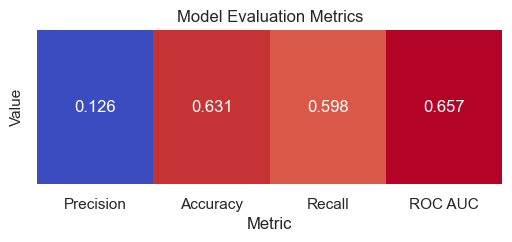

In [249]:
feature_importance_sub_data_clusters = help_model.model_feature_importance_target(sub_data_clusters.dropna(subset='TARGET'))

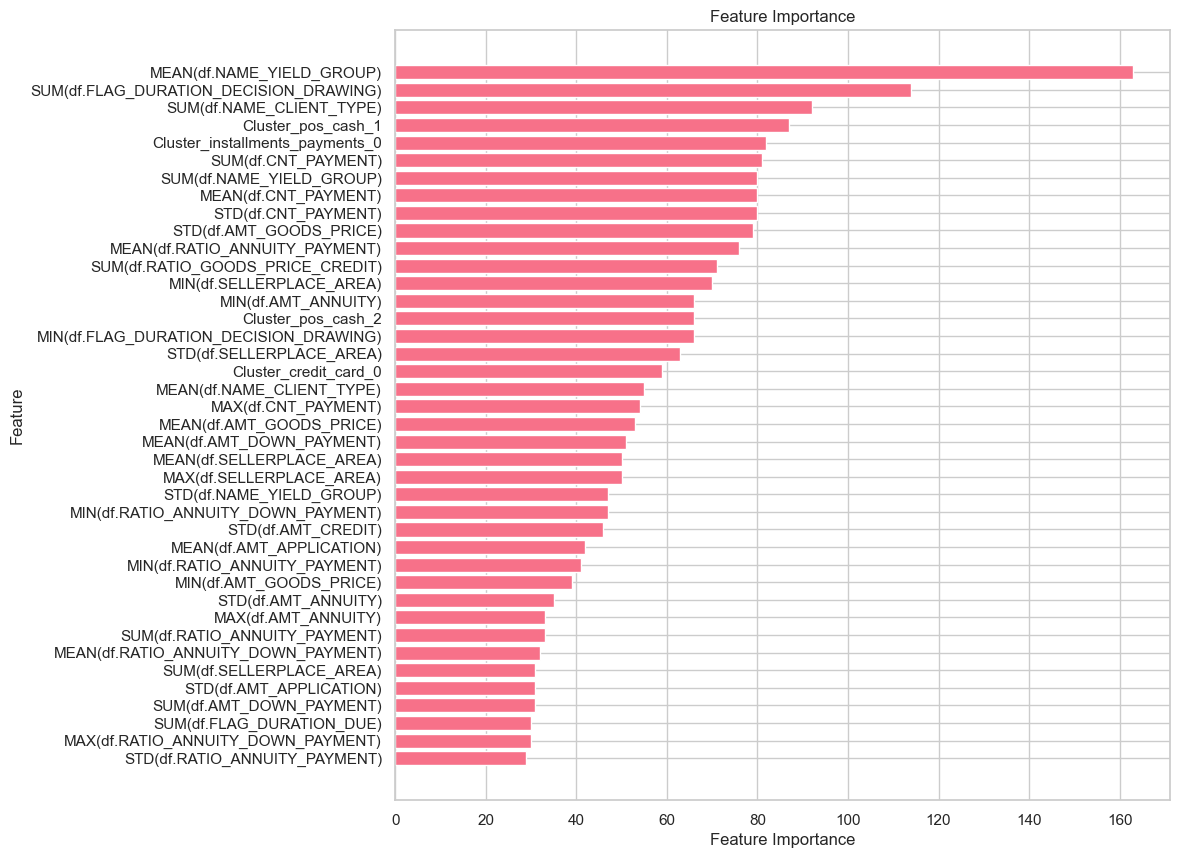

In [252]:
help_model.plot_feature_importance(feature_importance_sub_data_clusters.head(40))

Duration and clusters of pos_cash and instalment_payment seam to have some what of a linear relationship, but the scatterplots look distorted and these features will be left in.

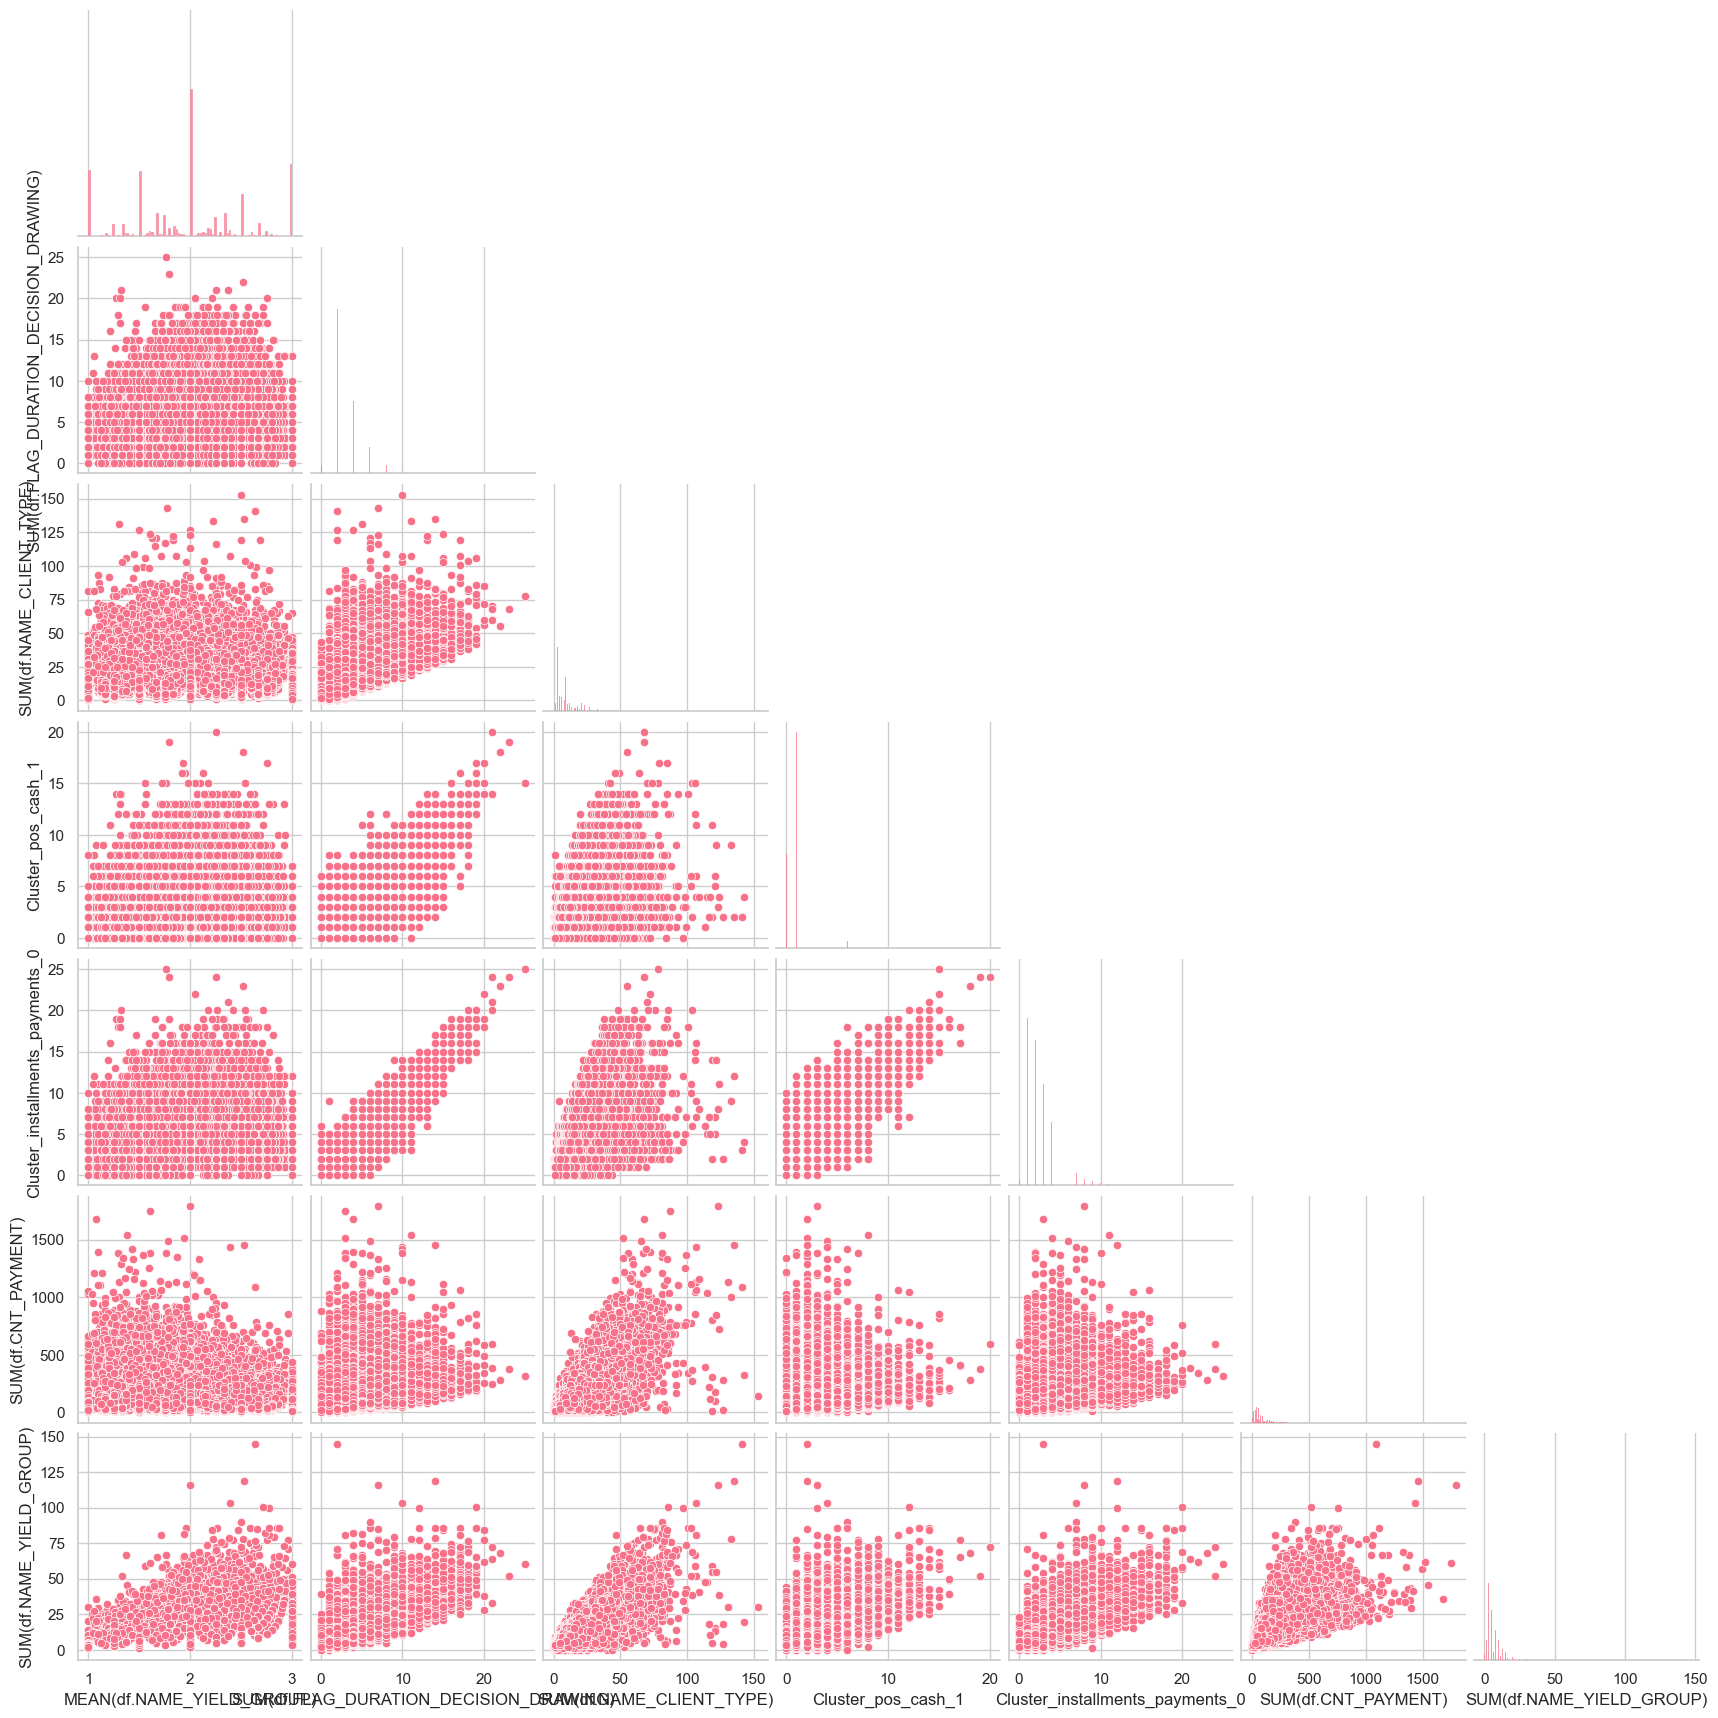

In [272]:
sns.pairplot(sub_data_clusters[feature_importance_sub_data_clusters['feature'].head(7).to_list()], corner=True)
plt.show()

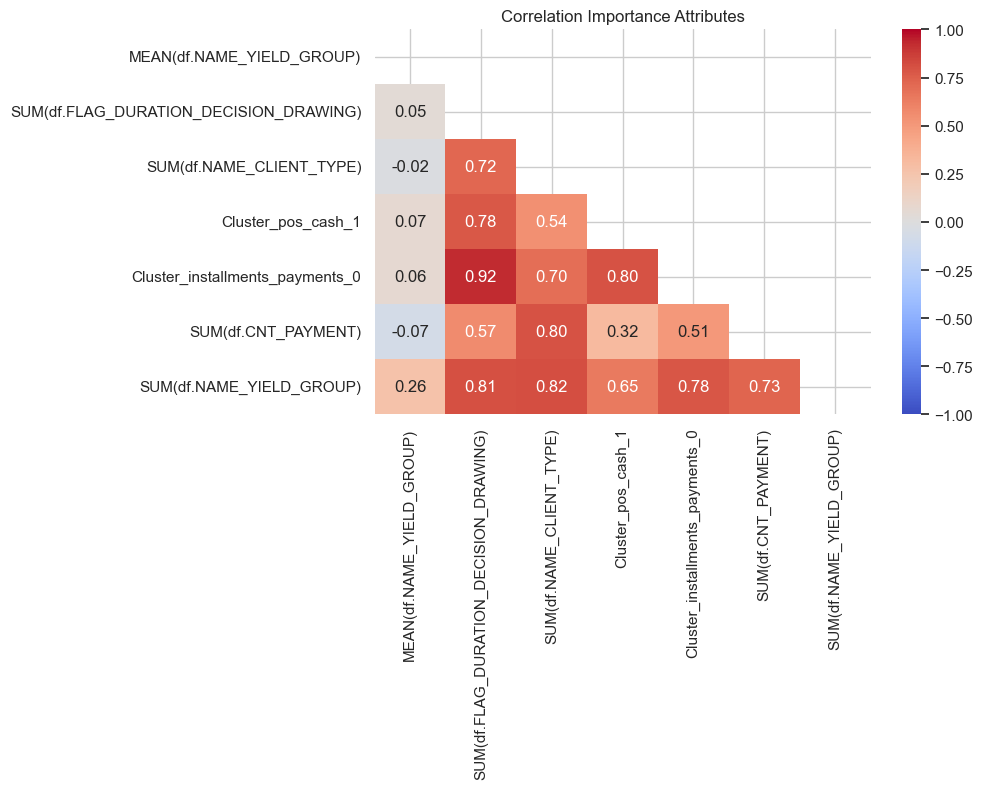

In [270]:
help_visuals.heatmap(sub_data_clusters[feature_importance_sub_data_clusters['feature'].head(7).to_list()], 'importance', 'pearson')

In [274]:
sub_data_clusters[['SK_ID_CURR'] + feature_importance_sub_data_clusters['feature'].head(7).to_list()]

,SK_ID_CURR,MEAN(df.NAME_YIELD_GROUP),SUM(df.FLAG_DURATION_DECISION_DRAWING),SUM(df.NAME_CLIENT_TYPE),Cluster_pos_cash_1,Cluster_installments_payments_0,SUM(df.CNT_PAYMENT),SUM(df.NAME_YIELD_GROUP)
0,131074,3.000000,2.0,2.5,1.0,2.0,12.0,6.0
1,257401,2.250000,4.0,7.0,2.0,4.0,52.0,9.0
2,341778,1.333333,3.0,7.0,1.0,2.0,90.0,4.0
3,451459,3.000000,3.0,11.0,1.0,3.0,28.0,9.0
4,317047,3.000000,1.0,1.0,0.0,1.0,12.0,3.0
...,...,...,...,...,...,...,...,...
338852,332437,2.000000,1.0,3.0,1.0,1.0,24.0,4.0
338853,294231,3.000000,1.0,1.0,0.0,1.0,12.0,3.0
338854,330972,1.750000,1.0,5.0,1.0,1.0,60.0,3.5
338855,228694,1.500000,1.0,9.0,1.0,1.0,84.0,6.0


In [275]:
sub_data_clusters[['SK_ID_CURR'] + feature_importance_sub_data_clusters['feature'].head(7).to_list()].to_csv(r'Archive\home-credit-default-risk\sub_data_clusters.csv')